# Model Testing and Creation

In [1]:
%%capture
!pip install sdv
!pip install tensorflow_decision_forests
!pip install tensorflow==2.18.0
!pip install scikeras

In [2]:
import numpy as np
import pandas as pd
from tensorflow import keras
from keras import *
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import csv
import seaborn as sns
# USED FOR GAN MODEL
import sdv
from sdv.metadata import Metadata
from sdv.single_table import CTGANSynthesizer
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality, get_column_plot
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import ydf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sdv.sampling import Condition
from sklearn.model_selection import StratifiedShuffleSplit

### Pull data and GAN model from GitHub

In [3]:
# Read the data hosted on my github
%%capture
data_url = "https://raw.githubusercontent.com/acard5meg/heatstroke_app/refs/heads/main/final_model/heat_stroke_data.csv"
data = pd.read_csv(data_url)
# shuffle data to destroy dependencies
data.sample(frac=1)

# Read GAN model hosted on Github
gan_url = "https://raw.githubusercontent.com/acard5meg/heatstroke_app/main/gan_model/best_gan_model.pkl"
gan_synth = pd.read_pickle(gan_url)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 609 entries, 0 to 608
Data columns (total 27 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Daily Ingested Water (L)                             609 non-null    float64
 1   Time of year (month)                                 609 non-null    float64
 2   Cardiovascular disease history                       609 non-null    int64  
 3   Dehydration                                          609 non-null    int64  
 4   Heat Index (HI)                                      609 non-null    float64
 5   Diastolic BP                                         609 non-null    float64
 6   Environmental temperature (C)                        609 non-null    float64
 7   Sickle Cell Trait (SCT)                              609 non-null    int64  
 8   Systolic BP                                          609 non-null    f

## Check GAN model upload has same number of parameters

In [5]:
gan_synth.get_parameters()

{'enforce_min_max_values': True,
 'enforce_rounding': True,
 'locales': ['en_US'],
 'embedding_dim': 128,
 'generator_dim': (256, 256),
 'discriminator_dim': (256, 256),
 'generator_lr': 0.0002,
 'generator_decay': 1e-06,
 'discriminator_lr': 0.02,
 'discriminator_decay': 1e-08,
 'batch_size': 500,
 'discriminator_steps': 1,
 'log_frequency': True,
 'verbose': True,
 'epochs': 300,
 'pac': 10,
 'cuda': True}

### Test GAN data validity against real data

In [6]:
# Create synthetic data
synthetic_data = gan_synth.sample(num_rows = 10000)

all_data = pd.concat([data,synthetic_data])

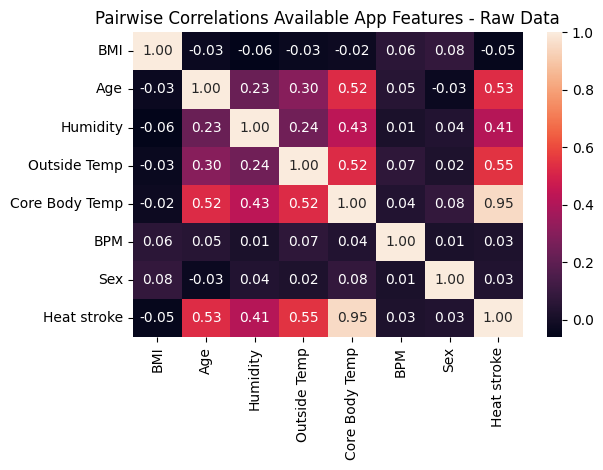

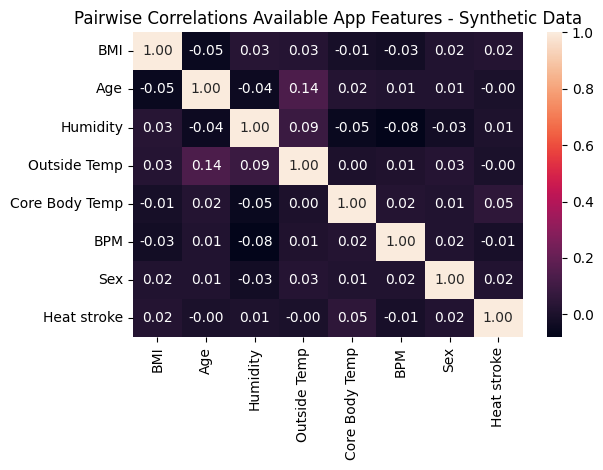

In [ ]:
pre_raw_data_corr = data[["BMI", "Age", "Relative Humidity", "Environmental temperature (C)", "Rectal temperature (deg C)", "Heart / Pulse rate (b/min)", "Sex", "Heat stroke"]]
pre_raw_data_corr.rename(columns={"Relative Humidity":"Humidity", "Environmental temperature (C)":"Outside Temp", "Rectal temperature (deg C)":"Core Body Temp", "Heart / Pulse rate (b/min)": "BPM"}, inplace=True)
raw_data_corr = pre_raw_data_corr.corr()

raw_data_ax = sns.heatmap(raw_data_corr, annot=True, fmt='.2f')
raw_data_ax.set_title("Pairwise Correlations Available App Features - Raw Data")
plt.tight_layout()
plt.savefig("correlations_raw_data.jpg")

plt.show()

pre_synth_data_corr = all_data[["BMI", "Age", "Relative Humidity", "Environmental temperature (C)", "Rectal temperature (deg C)", "Heart / Pulse rate (b/min)", "Sex", "Heat stroke"]]
pre_synth_data_corr.rename(columns={"Relative Humidity":"Humidity", "Environmental temperature (C)":"Outside Temp", "Rectal temperature (deg C)":"Core Body Temp", "Heart / Pulse rate (b/min)": "BPM"}, inplace=True)
synth_data_corr = pre_synth_data_corr.corr()
synth_data_ax = sns.heatmap(synth_data_corr, annot=True, fmt='.2f')
synth_data_ax.set_title("Pairwise Correlations Available App Features - Synthetic Data")
plt.tight_layout()
plt.savefig("correlations_synth_data.jpg")

plt.show()


### There is no documentation for the kaggle dataset. Need to determine encoding for 'sex' variable

In [ ]:
determine_sex = data[["Weight (kg)", "Sex", "BMI"]]

In [ ]:
determine_sex.drop(["BMI"], axis=1).groupby("Sex").mean()

,Weight (kg)
Sex,
0,47.59252
1,47.90044


### As shown above, the average weights are very close and very low. This doesn't give us much indication to the encoding. Because sex 0 is slightly lighter assume it's female.

In [ ]:
height = np.sqrt(determine_sex["Weight (kg)"].div(determine_sex["BMI"])).to_frame(name = "height")

In [ ]:
det_sex_w_height = determine_sex.join(height)

In [ ]:
det_sex_w_height.drop(["BMI", "Weight (kg)"], axis=1).groupby("Sex").mean()

,height
Sex,
0,1.515788
1,1.511706


### As shown above, height by sex are nearly identical.

### After investigation assume 0 is female

### Investigate relative humidity - Negative relative humidity is impossible remove these samples

array([[<Axes: title={'center': 'Relative Humidity'}>]], dtype=object)

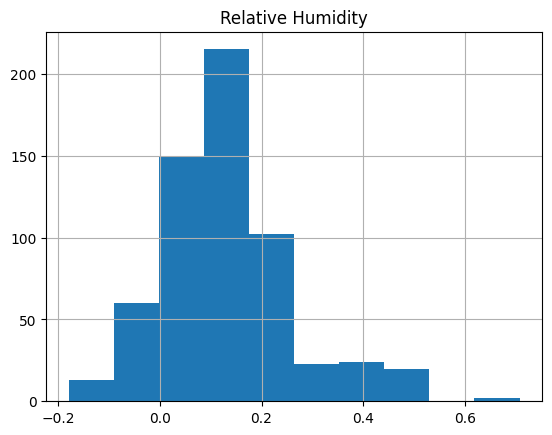

In [ ]:
rel_humidity = data[["Relative Humidity"]]
rel_humidity.hist()

In [ ]:
neg_values = 0
for i in range(len(rel_humidity)):
  if rel_humidity.iloc[i][0] < 0:
    neg_values += 1

tot = len(rel_humidity)
neg_humidity_real = neg_values / tot
print(f"Percentage of observations with negative humidity: {neg_humidity_real*100:.2f}%")


Percentage of observations with negative humidity: 12.64%


<ipython-input-14-fe44c8609ff9>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if rel_humidity.iloc[i][0] < 0:


### Investigate environmental temperature

array([[<Axes: title={'center': 'Environmental temperature (C)'}>]],
      dtype=object)

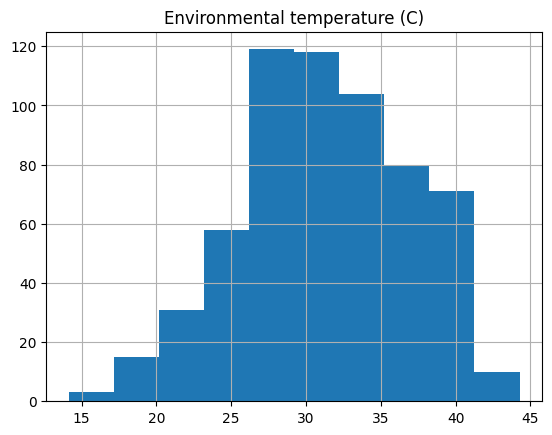

In [ ]:
temp = data[["Environmental temperature (C)"]]
temp.hist()

### Check Rectal Temperature

array([[<Axes: title={'center': 'Rectal temperature (deg C)'}>]],
      dtype=object)

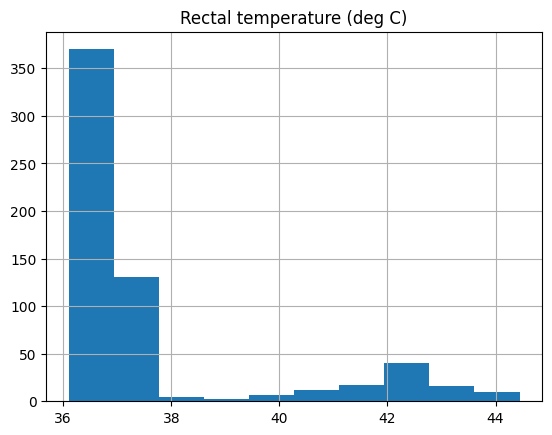

In [ ]:
data[["Rectal temperature (deg C)"]].hist()

### Check BPM

array([[<Axes: title={'center': 'Heart / Pulse rate (b/min)'}>]],
      dtype=object)

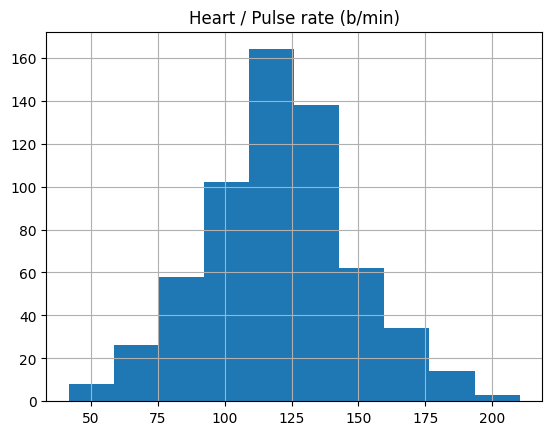

In [ ]:
data[["Heart / Pulse rate (b/min)"]].hist()

In [7]:
# Filter data to remove observatinos where relative humidity is less than 0
# which is impossible
neg_humidity_raw_data, raw_data_filtered = data.loc[data["Relative Humidity"] < 0], data.loc[data["Relative Humidity"] >= 0]

In [ ]:
print(f"Real data negative humidity percentage: {neg_humidity_real*100:.2f}%")

Real data negative humidity percentage: 12.64%


### Label comparison before and after negative humidity removal

In [ ]:
data_labels, data_cnts = np.unique(np.asarray(data[["Heat stroke"]]), return_counts=True)
filter_labels, filter_cnts = np.unique(np.asarray(raw_data_filtered[["Heat stroke"]]), return_counts=True)

print(f"Percent of unprocessed data with heatstroke: {data_cnts[1] / np.sum(data_cnts) * 100:.2f}%")
print(f"Percent of processed data with heatstroke: {filter_cnts[1] / np.sum(filter_cnts) * 100:.2f}%")

Percent of unprocessed data with heatstroke: 17.90%
Percent of processed data with heatstroke: 20.49%


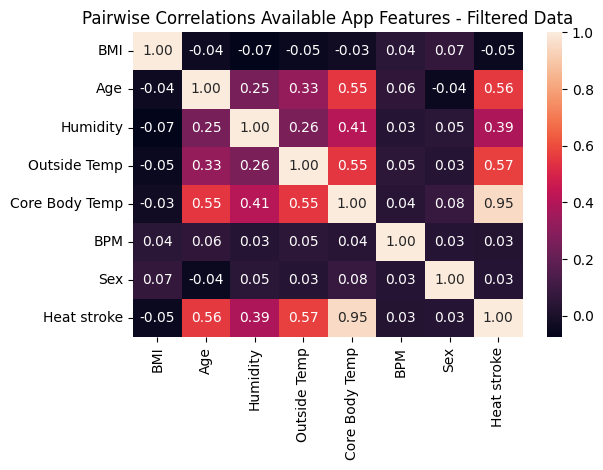

In [ ]:
pre_raw_data_filtered = raw_data_filtered[["BMI", "Age", "Relative Humidity", "Environmental temperature (C)", "Rectal temperature (deg C)", "Heart / Pulse rate (b/min)", "Sex", "Heat stroke"]]
pre_raw_data_filtered.rename(columns={"Relative Humidity":"Humidity", "Environmental temperature (C)":"Outside Temp", "Rectal temperature (deg C)":"Core Body Temp", "Heart / Pulse rate (b/min)": "BPM"}, inplace=True)
filter_data_corr = pre_raw_data_filtered.corr()
filter_data_ax = sns.heatmap(filter_data_corr, annot=True, fmt='.2f')
filter_data_ax.set_title("Pairwise Correlations Available App Features - Filtered Data")
plt.tight_layout()
plt.savefig("correlations_filter_raw_data.jpg")

plt.show()

In [9]:
raw_data_features = raw_data_filtered.drop(["Heat stroke"], axis=1)
raw_data_outcomes = raw_data_filtered[["Heat stroke"]]

print(raw_data_features.shape)
print(raw_data_outcomes.shape)

(532, 26)
(532, 1)


# Model split - Reduce feature vector to only variables used in app

In [10]:
def create_data(features):

  raw_data_features_model = raw_data_features[features]


  x_train, x_test, y_train, y_test = train_test_split(raw_data_features_model, raw_data_outcomes, test_size = 0.25, random_state = 42)
  x_train_data, x_val, y_train_data, y_val = train_test_split(x_train, y_train, test_size = 0.25, random_state = 42)

  def class_pct(arr, type_data):
      unq, cnt = np.unique(arr, return_counts = True)
      print(f"Breakdown of {type_data} data labels: {dict(zip(unq, (cnt / sum(cnt))*100))}")

  class_pct(raw_data_outcomes, "raw")
  class_pct(y_train_data, "training")
  class_pct(y_test, "testing")
  class_pct(y_val, "validation")

  return (x_train_data, x_val, y_train_data, y_val, x_test, y_test)

In [11]:
all_data = create_data(["BMI", "Age", "Relative Humidity", "Environmental temperature (C)",\
             "Rectal temperature (deg C)", "Heart / Pulse rate (b/min)", "Sex"])

x_train_data, x_val, y_train_data, y_val, x_test, y_test = all_data

Breakdown of raw data labels: {0: 79.51127819548873, 1: 20.48872180451128}
Breakdown of training data labels: {0: 82.2742474916388, 1: 17.725752508361204}
Breakdown of testing data labels: {0: 75.18796992481202, 1: 24.81203007518797}
Breakdown of validation data labels: {0: 77.0, 1: 23.0}


In [ ]:
# Convert data to tensors
def df_to_tensor(data):
    return tf.convert_to_tensor(data)

def convert_to_tensor(x_train_data, x_val, y_train_data, y_val, x_test, y_test):
  x_train_tensor = df_to_tensor(x_train_data)
  x_val_tensor = df_to_tensor(x_val)
  y_train_tensor = df_to_tensor(y_train_data)
  y_val_tensor = df_to_tensor(y_val)
  x_test_tensor = df_to_tensor(x_test)
  y_test_tensor = df_to_tensor(y_test)

  return (x_train_tensor, x_val_tensor, y_train_tensor, y_val_tensor, x_test_tensor, y_test_tensor)

In [ ]:
all_tensors = convert_to_tensor(x_train_data, x_val, y_train_data, y_val, x_test, y_test)
x_train_tensor, x_val_tensor, y_train_tensor, y_val_tensor, x_test_tensor, y_test_tensor = all_tensors

In [ ]:
y_train_values = y_train_data["Heat stroke"].tolist()

class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes = np.unique(y_train_data),
                                                 y = y_train_values)

c_w = {0:class_weights[0], 1:class_weights[1]}

In [ ]:
def create_model(opt, weights, x, y, x_val, y_val):
  normalization_layer = tf.keras.layers.Normalization(axis=-1)

  normalization_layer.adapt(x)

  model = Sequential()

  model.add(normalization_layer)

  model.add(keras.layers.Dense(1, # units, dimensionality of output space [prob heat stroke, prob not heat stroke]
                  activation = 'sigmoid', # activation function, for 2-D output sigmoid is acceptable
                  kernel_regularizer='l2', # regularization to prevent weights from exploding, assumes the default regularization weight of 0.01
                  input_shape = (x.shape) # input shape of the model tensor
                ))

  model.compile(
      optimizer = opt, # Name of optimizer, using vanilla SGD with default learning rate
      loss = 'binary_crossentropy', # Name of loss function. Using traditional cross entropy
      metrics=['accuracy', keras.metrics.F1Score(threshold=0.5, name="f1_score", dtype=None), keras.metrics.Recall(thresholds=0.5, name="recall")])

  hist = model.fit(x, y, epochs = 35, validation_data = (x_val, y_val), shuffle=True, verbose=0, class_weight = weights)

  return hist.history

In [ ]:
keras.utils.set_random_seed(42)

to_table = {}
model_tests = [("sgd_01_nw", keras.optimizers.SGD(0.01), None), ("sgd_0001_nw", keras.optimizers.SGD(0.0001), None),\
               ("sgd_01_w", keras.optimizers.SGD(0.01), c_w), ("sgd_0001_w", keras.optimizers.SGD(0.0001), c_w),\
               ("adam_001_nw", keras.optimizers.Adam(0.001), None), ("adam_0001_nw", keras.optimizers.Adam(0.0001), None),\
               ("adam_001_w", keras.optimizers.Adam(0.001), c_w), ("adam_0001_w", keras.optimizers.Adam(0.0001), c_w)]

for name, opt, weight in model_tests:
  to_table[name] = {}

  testing = create_model(opt, weight, x_train_tensor, y_train_tensor, x_val_tensor, y_val_tensor)

  for i in testing.keys():
    to_table[name][i] = sum(testing[i])/len(testing[i])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
grid_search_7f = pd.DataFrame(to_table).T
grid_search_7f.to_csv("seven_feature_grid_search.csv")

### Create Model Using 4 Highly Correlated Features

In [ ]:
all_data_4f = create_data(["Age", "Relative Humidity", "Environmental temperature (C)",\
             "Rectal temperature (deg C)"])

x_train_data_4f, x_val_4f, y_train_data_4f, y_val_4f, x_test_4f, y_test_4f = all_data_4f

Breakdown of raw data labels: {0: 79.51127819548873, 1: 20.48872180451128}
Breakdown of training data labels: {0: 82.2742474916388, 1: 17.725752508361204}
Breakdown of testing data labels: {0: 75.18796992481202, 1: 24.81203007518797}
Breakdown of validation data labels: {0: 77.0, 1: 23.0}


In [ ]:
all_tensors_4f = convert_to_tensor(x_train_data_4f, x_val_4f, y_train_data_4f, y_val_4f, x_test_4f, y_test_4f)
x_train_tensor_4f, x_val_tensor_4f, y_train_tensor_4f, y_val_tensor_4f, x_test_tensor_4f, y_test_tensor_4f = all_tensors_4f

In [ ]:
y_train_values_4f = y_train_data_4f["Heat stroke"].tolist()

class_weights_4f = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes = np.unique(y_train_data_4f),
                                                 y = y_train_values_4f)

c_w_4f = {0:class_weights[0], 1:class_weights[1]}

In [ ]:
keras.utils.set_random_seed(42)

to_table_4f = {}
model_tests_4f = [("sgd_01_nw", keras.optimizers.SGD(0.01), None), ("sgd_0001_nw", keras.optimizers.SGD(0.0001), None),\
               ("sgd_01_w", keras.optimizers.SGD(0.01), c_w), ("sgd_0001_w", keras.optimizers.SGD(0.0001), c_w),\
               ("adam_001_nw", keras.optimizers.Adam(0.001), None), ("adam_0001_nw", keras.optimizers.Adam(0.0001), None),\
               ("adam_001_w", keras.optimizers.Adam(0.001), c_w), ("adam_0001_w", keras.optimizers.Adam(0.0001), c_w)]

for name, opt, weight in model_tests_4f:
  to_table_4f[name] = {}

  testing_4f = create_model(opt, weight, x_train_tensor_4f, y_train_tensor_4f, x_val_tensor_4f, y_val_tensor_4f)

  for i in testing_4f.keys():
    to_table_4f[name][i] = sum(testing_4f[i])/len(testing_4f[i])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
grid_search_4f = pd.DataFrame(to_table_4f).T
grid_search_4f.to_csv("four_feature_grid_search.csv")

### After looking through all the trials, 4 features with SGD 0.01 learning rate and no weighting is the clear winner

### FINAL MODEL

In [ ]:
keras.utils.set_random_seed(42)

normalization_layer = tf.keras.layers.Normalization(axis=-1)

normalization_layer.adapt(x_train_tensor_4f)

final_model = Sequential()

final_model.add(normalization_layer)

final_model.add(keras.layers.Dense(1, # units, dimensionality of output space [prob heat stroke, prob not heat stroke]
                activation = 'sigmoid', # activation function, for 2-D output sigmoid is acceptable
                kernel_regularizer='l2', # regularization to prevent weights from exploding, assumes the default regularization weight of 0.01
                input_shape = (x_train_tensor_4f.shape) # input shape of the model tensor
              ))

final_model.compile(
    optimizer = keras.optimizers.SGD(0.01), # Name of optimizer
    loss = 'binary_crossentropy', # Name of loss function. Using traditional cross entropy
    metrics=['accuracy', keras.metrics.F1Score(threshold=0.5, name="f1_score", dtype=None), keras.metrics.Recall(thresholds=0.5, name="recall")])

final_model_hist = final_model.fit(x_train_tensor_4f, y_train_tensor_4f, \
                                  epochs = 35, \
                                  validation_data = (x_val_tensor_4f, y_val_tensor_4f), \
                                  shuffle=True,
                                  verbose = 0)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
final_model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_18 (Normalization)     │ (None, 4)                   │               9 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16 (72.00 B)

 Trainable params: 5 (20.00 B)

 Non-trainable params: 9 (40.00 B)

 Optimizer params: 2 (12.00 B)

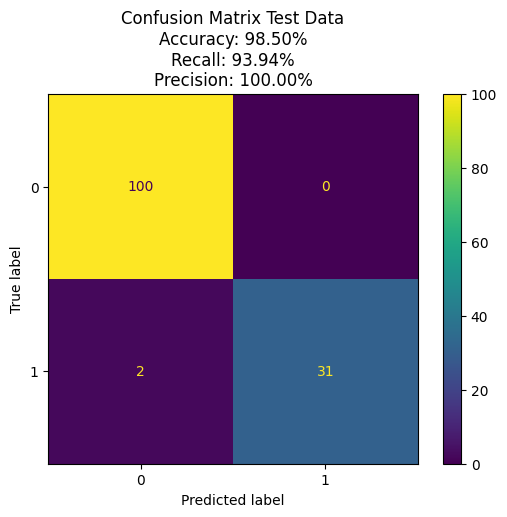

In [ ]:
new_predicted_train_labels = final_model.predict(x_test_tensor_4f, verbose=0)
true_train_labels = np.asarray(y_test_tensor_4f)

for i in range(len(new_predicted_train_labels)):
  if new_predicted_train_labels[i] >= 0.5:
    new_predicted_train_labels[i] = 1
  else:
    new_predicted_train_labels[i] = 0

cm = confusion_matrix(true_train_labels,new_predicted_train_labels)
model_acc = (cm[0,0] + cm[1,1])/np.sum(cm)
model_recall = recall_score(true_train_labels,new_predicted_train_labels)
model_precision = precision_score(true_train_labels,new_predicted_train_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.ax_.set_title(f"Confusion Matrix Test Data\nAccuracy: {model_acc*100:.2f}%\nRecall: {model_recall*100:.2f}%\nPrecision: {model_precision*100:.2f}%")
disp.figure_.savefig("conf_matrix_test_data.jpg", bbox_inches='tight')



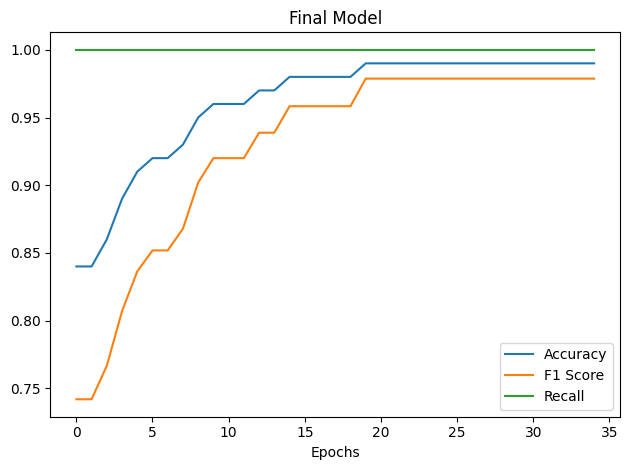

In [ ]:
hist_d = final_model_hist.history
acc, f1, loss, recall = hist_d['val_accuracy'], hist_d['val_f1_score'], hist_d['val_loss'], hist_d['val_recall']

x_axis = np.arange(len(acc))

plt.plot(x_axis, acc, label="Accuracy")
plt.plot(x_axis, f1, label="F1 Score")
plt.plot(x_axis, recall, label = "Recall")
plt.title("Final Model")
plt.xlabel("Epochs")
plt.legend()
plt.tight_layout()
plt.savefig("final_model_stats.jpg")
plt.show()

### Convert to TFLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
tfmodel = converter.convert()
open("final_model.tflite","wb").write(tfmodel)
print('Float model size = %dKBs.' % (len(tfmodel)/1024))

Saved artifact at '/tmp/tmpsc1mdwe3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4), dtype=tf.float32, name='keras_tensor_177')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138848662873616: TensorSpec(shape=(1, 4), dtype=tf.float32, name=None)
  138848661933216: TensorSpec(shape=(1, 4), dtype=tf.float32, name=None)
  138848565450656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138848565458224: TensorSpec(shape=(), dtype=tf.resource, name=None)
Float model size = 1KBs.


## For comparison, run decision trees. Not exportable to TFLite

### Based in paper
1. Data-driven advice for applying machine learning to bioinformatics problems: Olson, La Cava, Mustahsan, Varik, Moore

In [12]:
dt_train_data = pd.concat([x_train_data, y_train_data], axis=1)
dt_val_data = pd.concat([x_val, y_val], axis=1)
dt_test_data = pd.concat([x_test, y_test], axis=1)

In [13]:
gradient_boosted = ydf.GradientBoostedTreesLearner(label="Heat stroke").train(dt_train_data)
gradient_boosted_eval = gradient_boosted.evaluate(dt_val_data)
print(gradient_boosted_eval)

Train model on 299 examples
Model trained in 0:00:00.433966
accuracy: 1
confusion matrix:
    label (row) \ prediction (col)
    +----+----+----+
    |    |  0 |  1 |
    +----+----+----+
    |  0 | 77 |  0 |
    +----+----+----+
    |  1 |  0 | 23 |
    +----+----+----+
characteristics:
    name: '1' vs others
    ROC AUC: 1
    PR AUC: 1
    Num thresholds: 28
loss: 2.28883e-06
num examples: 100
num examples (weighted): 100



In [14]:
random_forest = ydf.RandomForestLearner(label="Heat stroke").train(dt_train_data)
random_forest_eval = random_forest.evaluate(dt_val_data)
print(random_forest_eval)

Train model on 299 examples
Model trained in 0:00:00.037938
accuracy: 1
confusion matrix:
    label (row) \ prediction (col)
    +----+----+----+
    |    |  0 |  1 |
    +----+----+----+
    |  0 | 77 |  0 |
    +----+----+----+
    |  1 |  0 | 23 |
    +----+----+----+
characteristics:
    name: '1' vs others
    ROC AUC: 1
    PR AUC: 1
    Num thresholds: 22
loss: 0.0103691
num examples: 100
num examples (weighted): 100

